In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 5)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import math


**Loading & Dataset**

In [2]:
data = pd.read_csv('KaggleV2-May-2016.csv')


**Feature Exploration**

In [3]:
print(len(data))
data.head()

110527


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
for column in data.columns:
    print(f"{column:25} {data[column].nunique()}")


PatientId                 62299
AppointmentID             110527
Gender                    2
ScheduledDay              103549
AppointmentDay            27
Age                       104
Neighbourhood             81
Scholarship               2
Hipertension              2
Diabetes                  2
Alcoholism                2
Handcap                   5
SMS_received              2
No-show                   2


**Data Visualization**

In [5]:

def features_plots(discrete_vars):
    continuous_vars = ['Age', 'AwaitingTime']
    total_plots = len(continuous_vars) + len(discrete_vars)
    cols = 2
    rows = math.ceil(total_plots / cols)

    plt.figure(figsize=(15, rows * 4))

    all_vars = continuous_vars + discrete_vars

    for i, var in enumerate(all_vars):
        plt.subplot(rows, cols, i + 1)
        if var in continuous_vars:
            plt.hist(data[var], bins=30, color='blue', edgecolor='black')
            plt.title(f"Histogram of {var}")
            plt.xlabel(var)  # X-axis label
            plt.ylabel("Frequency")
        else:
            data[var].value_counts().plot(kind='bar', color='blue')
            plt.title(f"Bar Chart of {var}")
            plt.xlabel(var)  # X-axis label
            plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()




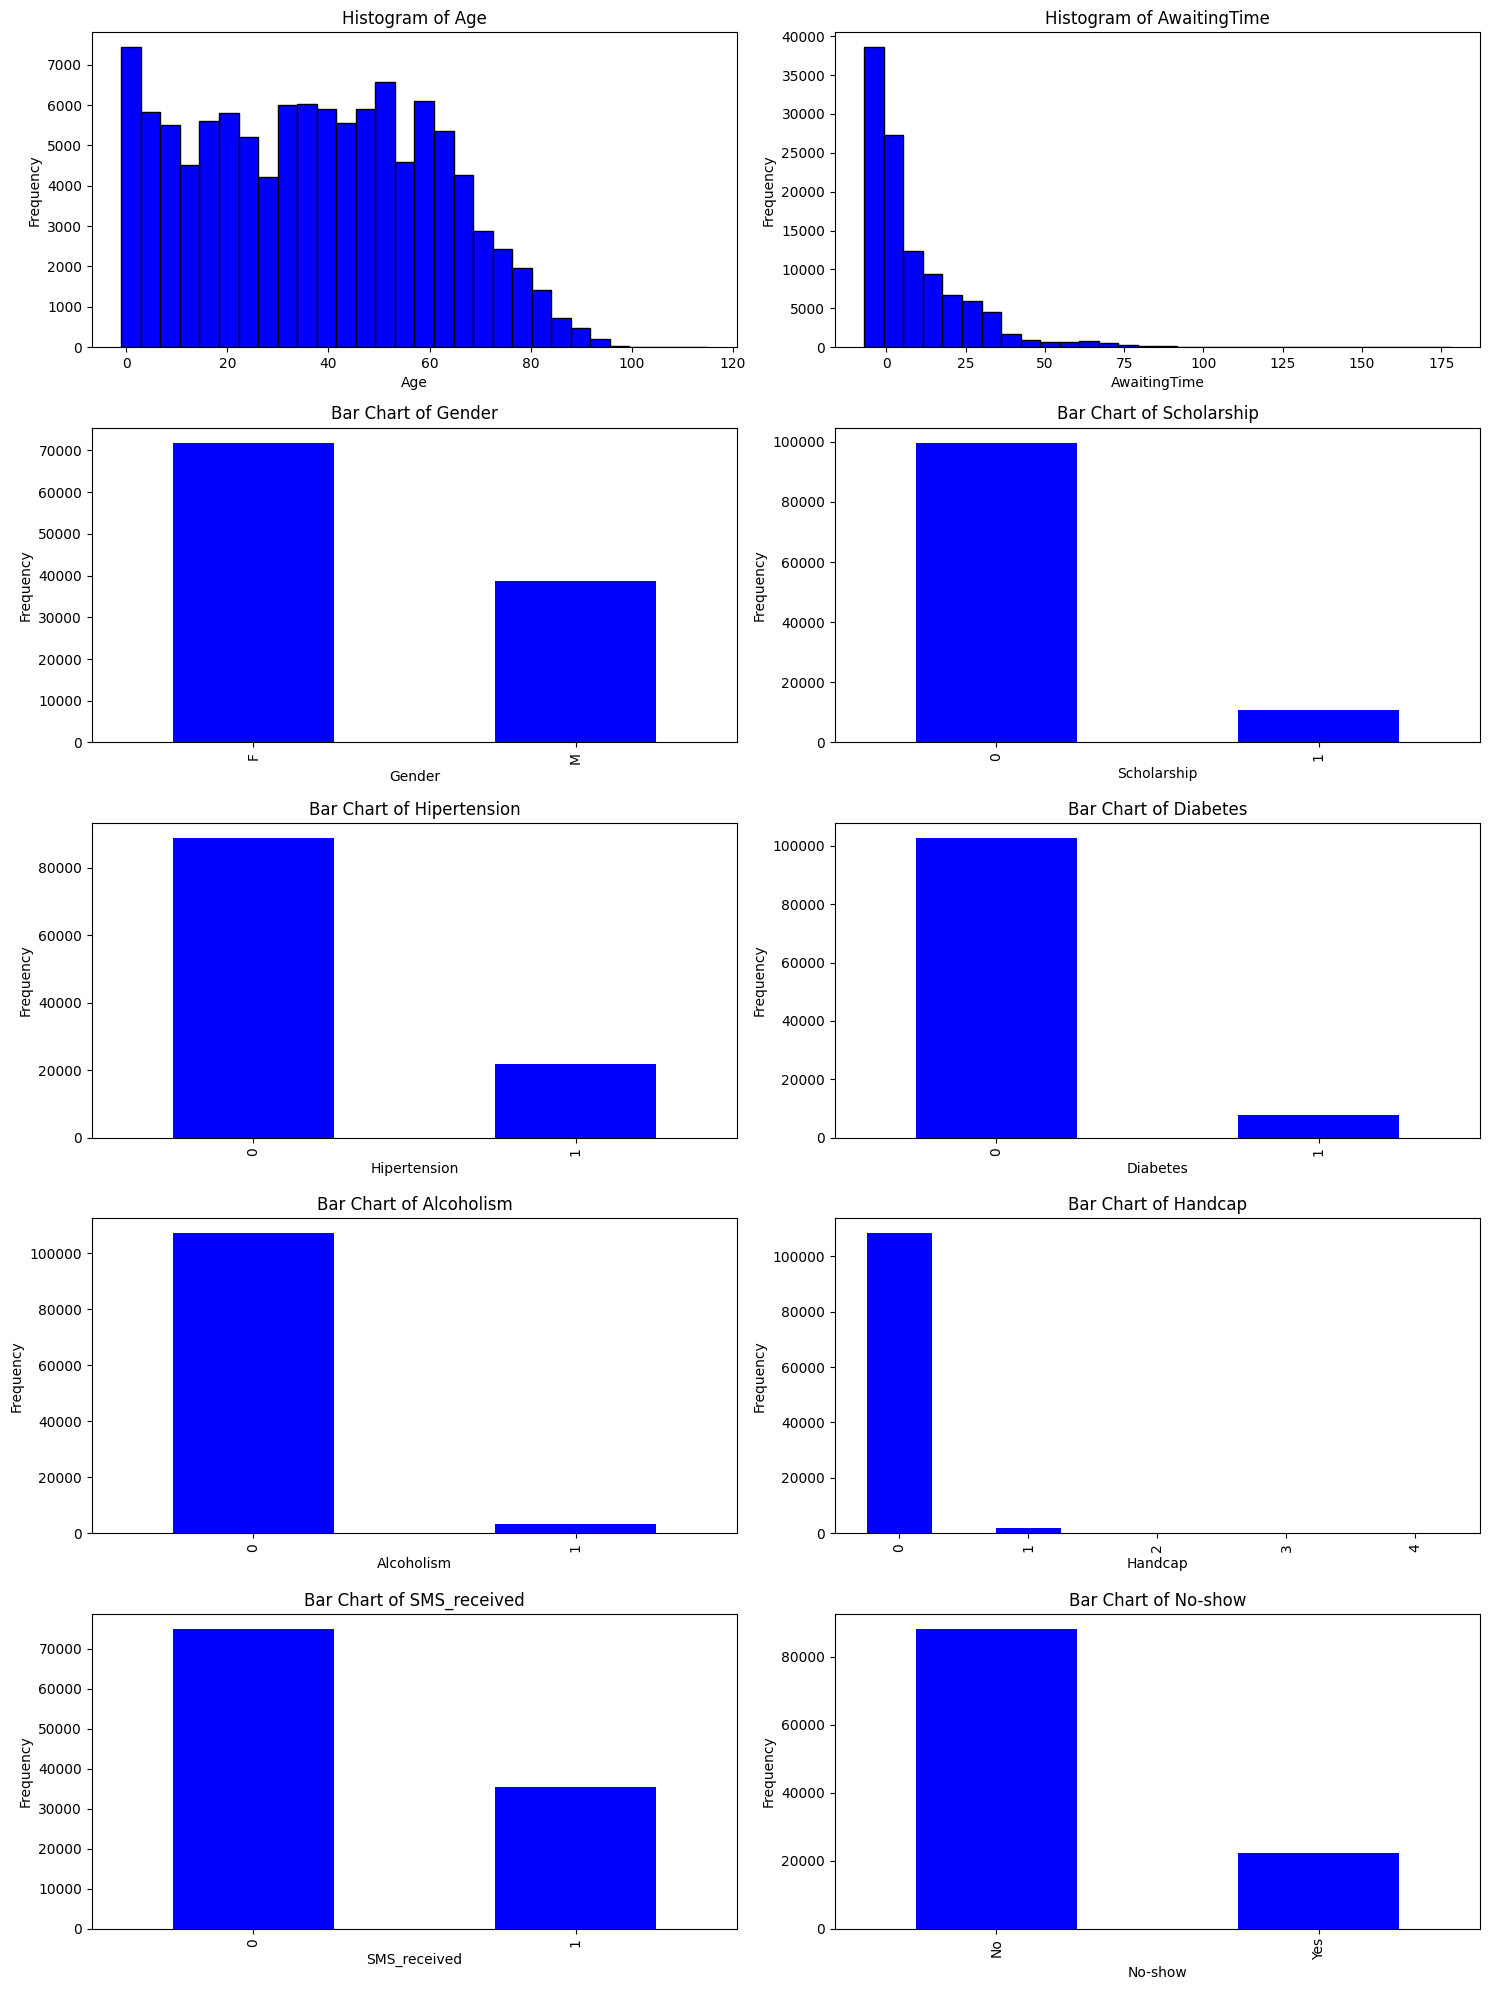

In [ ]:

data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])

data['AwaitingTime'] = (data['AppointmentDay'] - data['ScheduledDay']).dt.days

discrete_vars = [
    'Gender',
    'Scholarship',
    'Hipertension',
    'Diabetes',
    'Alcoholism',
    'Handcap',
    'SMS_received',
    'No-show'
]

features_plots( discrete_vars)


**Checking Null Values**

In [7]:
data.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
AwaitingTime      0
dtype: int64

**Feature Selection**

In [8]:
data = data.drop(columns=['Handcap'])

In [9]:
data['AwaitingTime'] = data['AwaitingTime'].apply(lambda x: abs(x))

**Data Encoding(Label Encoding)**

In [10]:
gender_mapping = {'F': 0, 'M': 1}
data['Gender'] = data['Gender'].map(gender_mapping)


**Data Encoding(One-Hot Encoding)**

In [11]:
data = pd.get_dummies(data, columns=['Neighbourhood'], prefix='Nbhd')


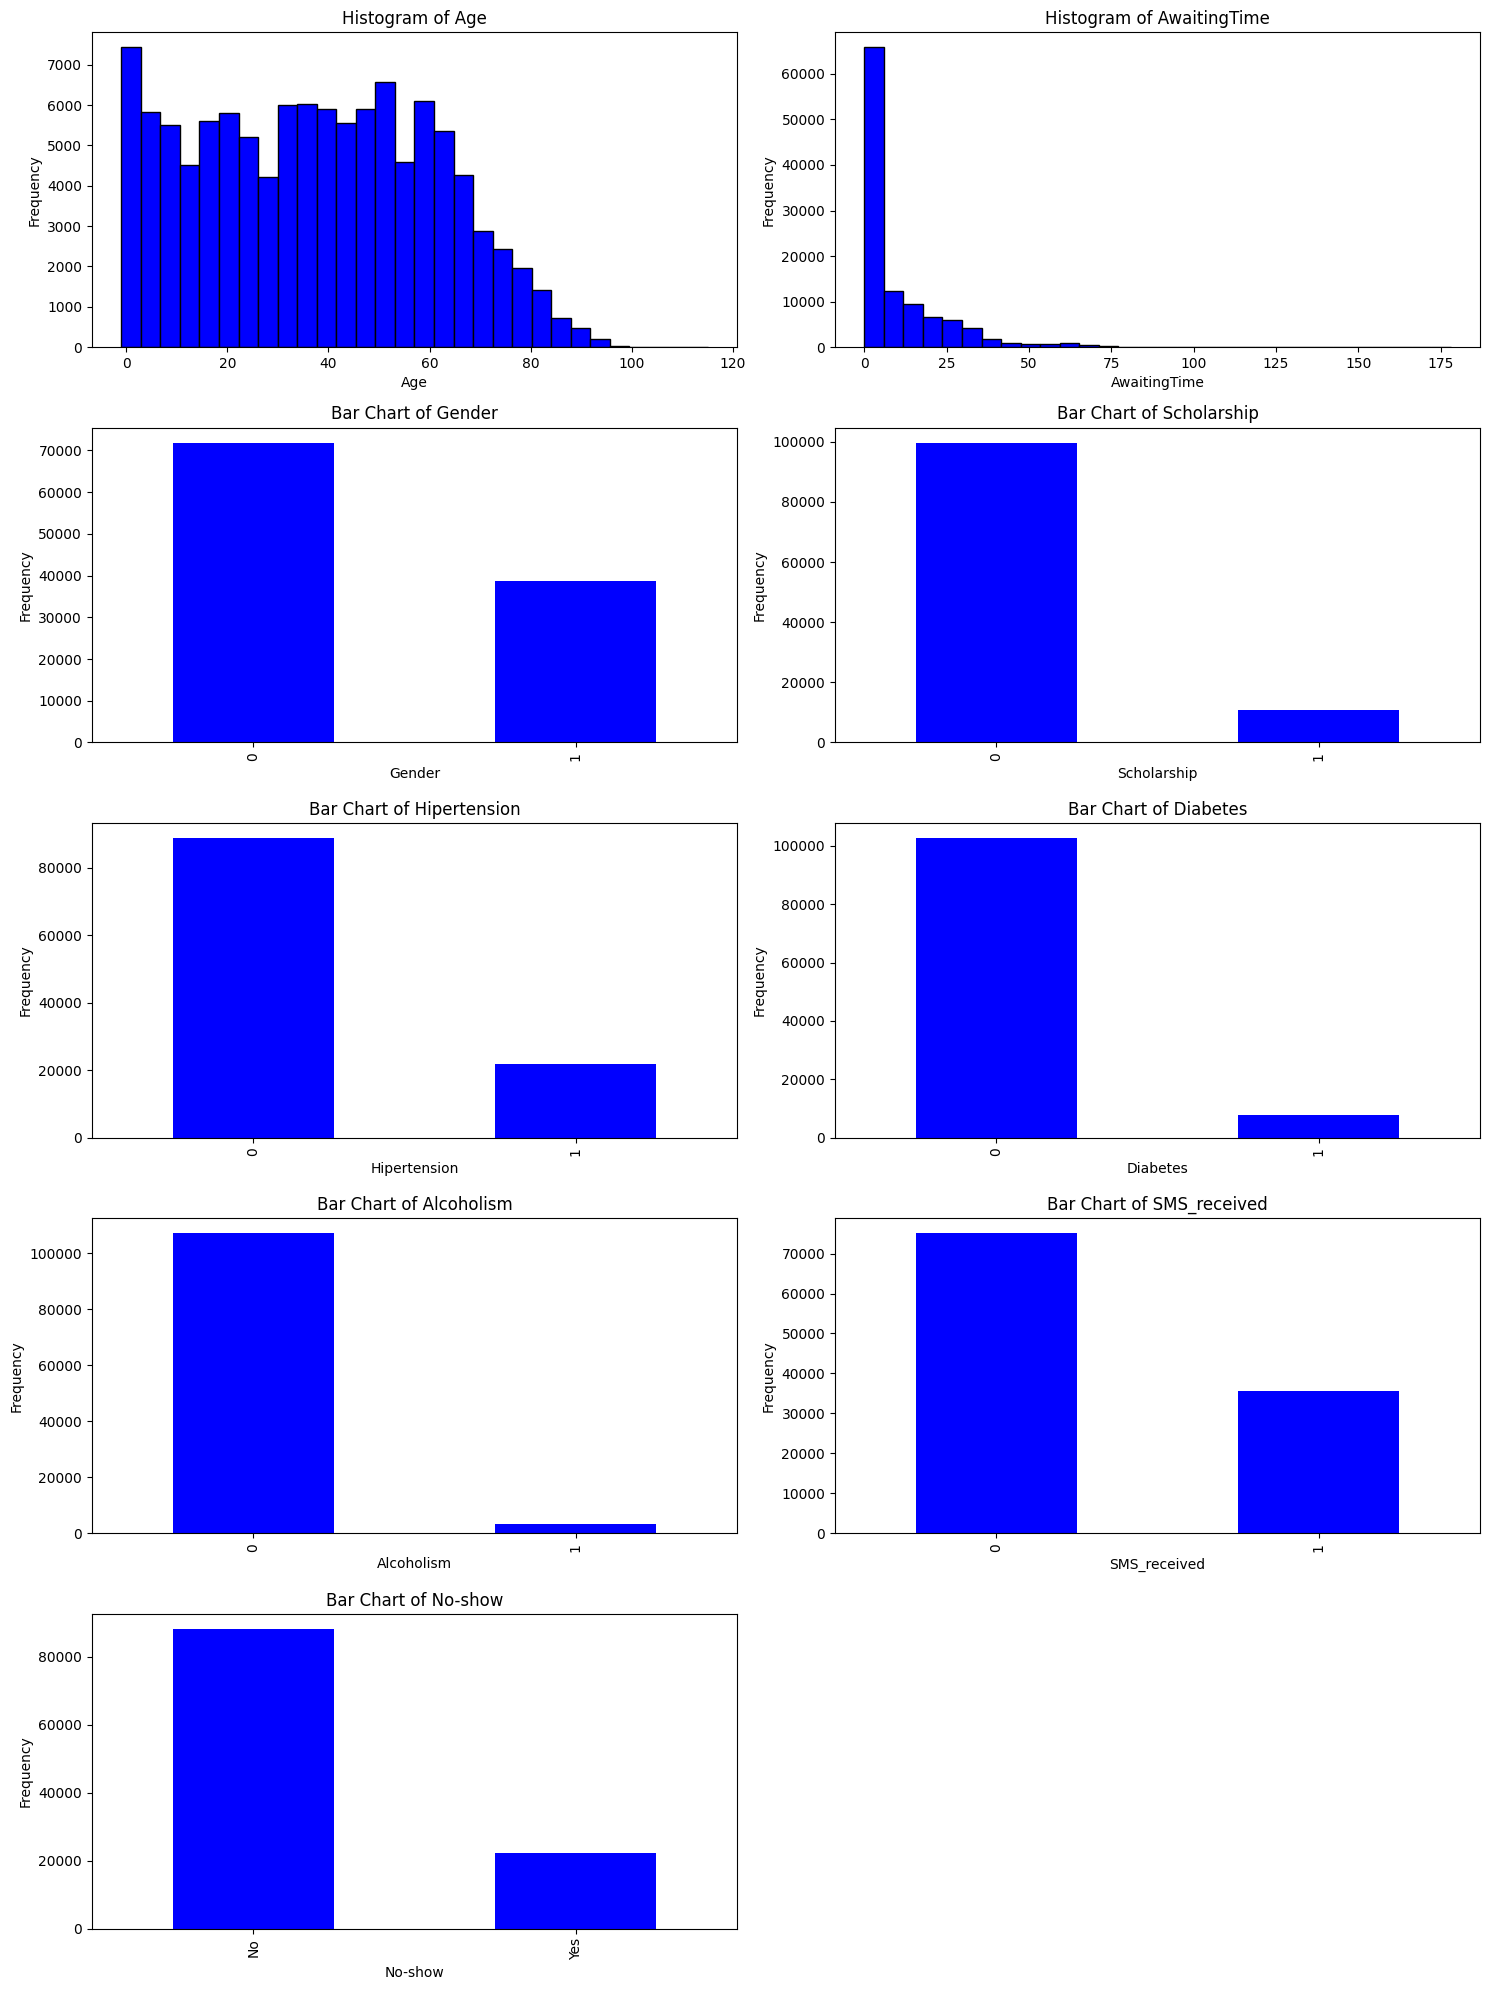

In [12]:
discrete_vars = [
    'Gender',
    'Scholarship',
    'Hipertension',
    'Diabetes',
    'Alcoholism',
    'SMS_received',
    'No-show'
]
features_plots( discrete_vars)

**Exploratory Data Analysis**

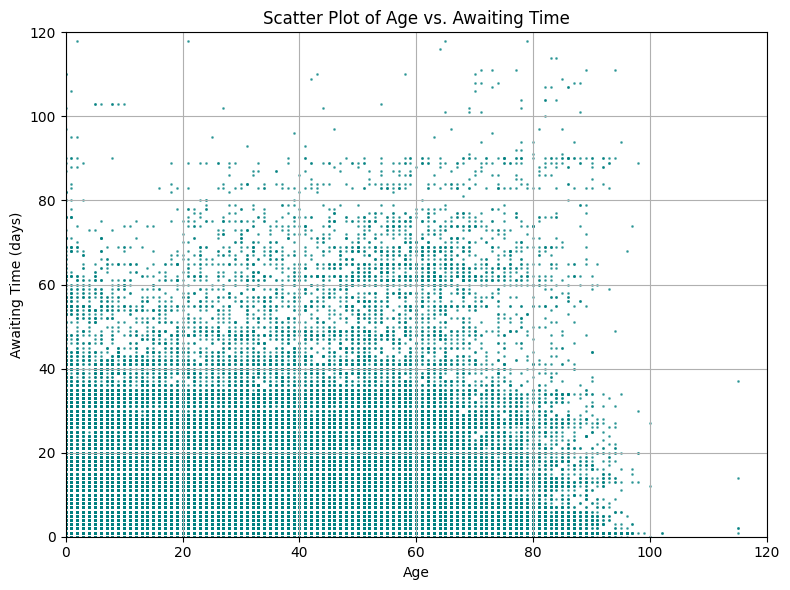

In [13]:

plt.figure(figsize=(8, 6))
plt.scatter(data['Age'], data['AwaitingTime'], s=1, alpha=0.6, color='teal')
plt.title('Scatter Plot of Age vs. Awaiting Time')
plt.xlabel('Age')
plt.ylabel('Awaiting Time (days)')
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.grid(True)
plt.tight_layout()
plt.show()


The scatter plot indicates that waiting time decreases with increasing age, particularly noticeable after age 40.

In [14]:
# Set display options (optional for better output formatting)
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)

# Compute Pearson correlation
correlations = data[['Age', 'AwaitingTime']].corr(method='pearson')

# Print correlation matrix
print(correlations)


               Age  AwaitingTime
Age           1.00          0.03
AwaitingTime  0.03          1.00


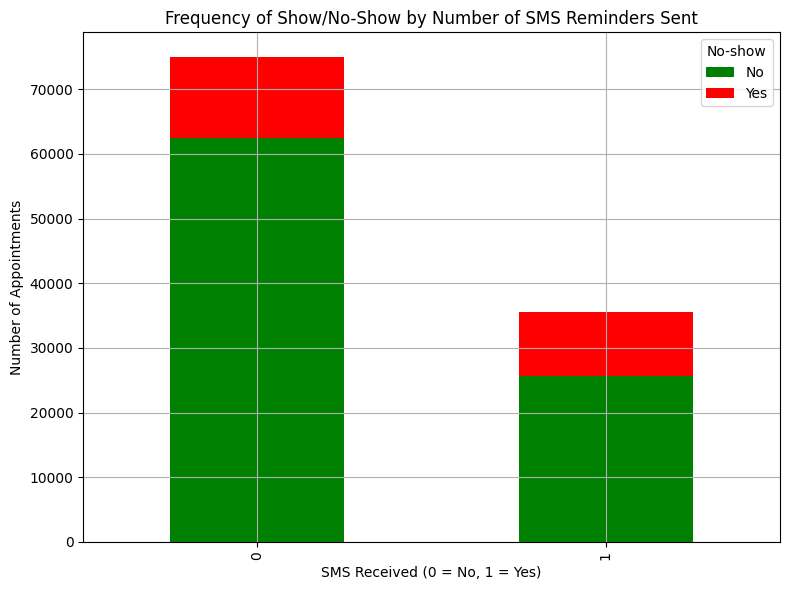

In [15]:

data_dow_status = data.groupby(['SMS_received', 'No-show'])['SMS_received'] \
                      .count().unstack('No-show').fillna(0)

# Plot as stacked bar chart
data_dow_status[[ 'No', 'Yes']].plot(kind='bar', stacked=True, figsize=(8, 6), color=['green', 'red'])

plt.title('Frequency of Show/No-Show by Number of SMS Reminders Sent')
plt.xlabel('SMS Received (0 = No, 1 = Yes)')
plt.ylabel('Number of Appointments')
plt.legend(title='No-show')
plt.tight_layout()
plt.grid(True)
plt.show()


The "Yes" category (SMS received) has a lower proportion of no-shows compared to the "No" category (SMS not received). 

Where no-shows constitute a larger portion 70,000, indicating SMS reminders improve attendance.

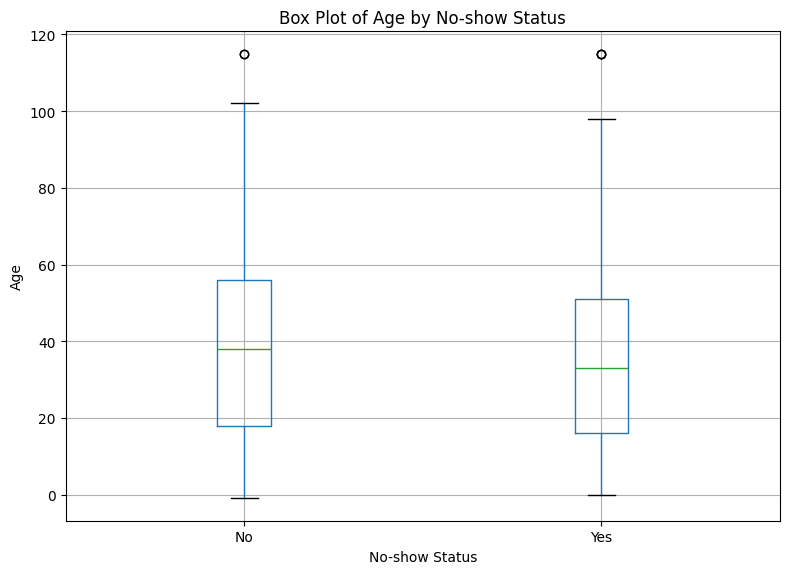

In [16]:

# Box plot of Age grouped by No-show status
data.boxplot(column='Age', by='No-show', figsize=(8, 6))
plt.title('Box Plot of Age by No-show Status')
plt.suptitle('')  # Removes the default Pandas title
plt.xlabel('No-show Status')
plt.ylabel('Age')
plt.grid(True)
plt.tight_layout()
plt.show()


The box plot shows similar age distributions for both attended and missed appointments, with outliers up to 120 in both groups.




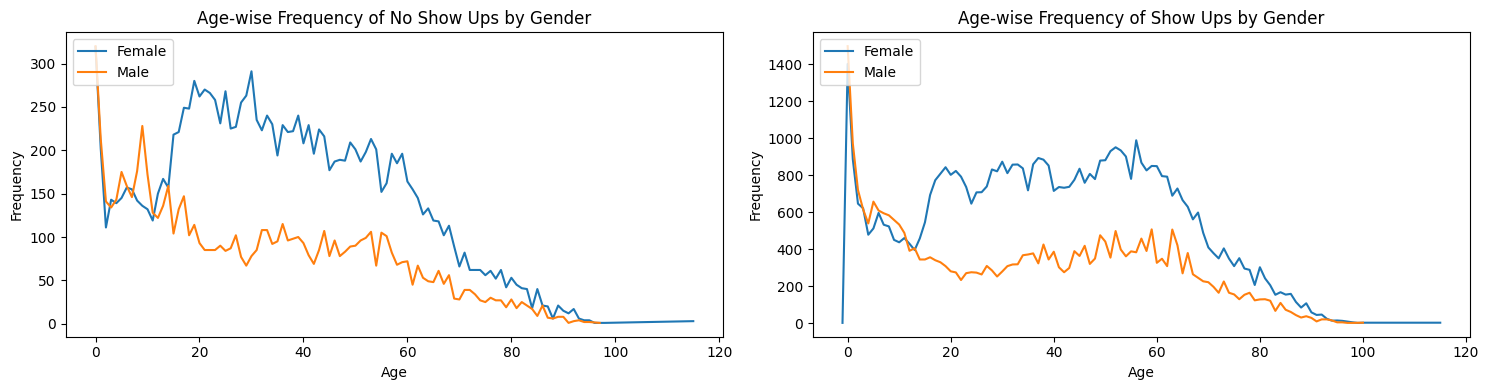

In [ ]:

plt.figure(figsize=(15, 4))

status_labels = {1: 'no show ups', 0: 'show ups'}
gender_labels = {0: 'Female', 1: 'Male'}

for i, (status_val, status_name) in enumerate(status_labels.items()):
    data_show = data[data['No-show'].map({'No': 0, 'Yes': 1}) == status_val]
    
    plt.subplot(1, 2, i + 1)
    for gender_val in [0, 1]:
        data_gender = data_show[data_show['Gender'] == gender_val]
        freq_age = data_gender['Age'].value_counts().sort_index()
        freq_age.plot()

    plt.title(f'Age-wise Frequency of {status_name.title()} by Gender')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend([gender_labels[0], gender_labels[1]], loc='upper left')

plt.tight_layout()
plt.show()


The plots show that for both no-shows and show-ups, females (blue) and males (orange) have higher frequencies at younger ages (0-20), with frequencies declining with age
No-shows peak higher for males initially, while show-ups are more balanced but decline similarly for both genders after age 20.

In [ ]:
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])

for col in ['ScheduledDay', 'AppointmentDay']:
    data[f'{col}_year'] = data[col].dt.year
    data[f'{col}_month'] = data[col].dt.month
    data[f'{col}_day'] = data[col].dt.day


In [19]:
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['ScheduledDay_hour'] = data['ScheduledDay'].dt.hour
data['ScheduledDay_minute'] = data['ScheduledDay'].dt.minute
data['ScheduledDay_second'] = data['ScheduledDay'].dt.second
data.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,...,Nbhd_VILA RUBIM,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day,ScheduledDay_hour,ScheduledDay_minute,ScheduledDay_second
0,2.987e+13,5642903,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,...,False,2016,4,29,2016,4,29,18,38,8
1,5.590e+14,5642503,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,...,False,2016,4,29,2016,4,29,16,8,27
2,4.263e+12,5642549,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,0,...,False,2016,4,29,2016,4,29,16,19,4
3,8.680e+11,5642828,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,0,...,False,2016,4,29,2016,4,29,17,29,31
4,8.841e+12,5642494,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,1,0,...,False,2016,4,29,2016,4,29,16,7,23


**Evaluation Metrics**

In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt

def model_performance(model_name, X_train, y_train, y_test, y_pred, clf=None):
    print(f'Model name: {model_name}')
    print(f'Test accuracy (Accuracy Score): {metrics.accuracy_score(y_test, y_pred):.4f}')
    print(f'Test accuracy (ROC AUC Score): {metrics.roc_auc_score(y_test, y_pred):.4f}')
    
    if clf:
        print(f'Train accuracy: {clf.score(X_train, y_train):.4f}')

    # Precision-Recall Curve
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    pr_auc = metrics.auc(recall, precision)
    print(f'Area Under the Precision-Recall Curve: {pr_auc:.4f}')

    # ROC Curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
features_of_choice = [
    'Age', 'Gender', 'Diabetes', 'Alcoholism', 'Hipertension',
    'Scholarship', 'SMS_received', 'AwaitingTime'
] + [col for col in data.columns if col.startswith('Nbhd_')] + [
    'ScheduledDay_year', 'ScheduledDay_month', 'ScheduledDay_day',
    'AppointmentDay_year', 'AppointmentDay_month', 'AppointmentDay_day',
    'ScheduledDay_hour', 'ScheduledDay_minute', 'ScheduledDay_second'
]

# Ensure the same feature set is used for both train and test
X = data[features_of_choice]
y = data['No-show'].map({'No': 0, 'Yes': 1})  # or whatever your target encoding is

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


**Decision Tree Classifier**

Model name: Decision Tree Classifier
Test accuracy (Accuracy Score): 0.7273
Test accuracy (ROC AUC Score): 0.5788
Train accuracy: 0.9999
Area Under the Precision-Recall Curve: 0.3954


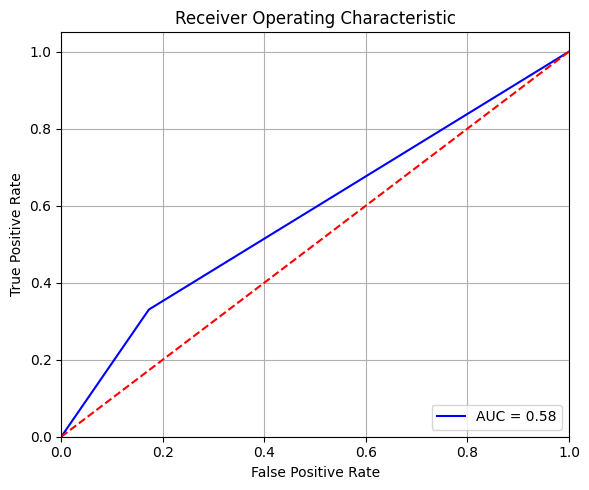

In [22]:

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
model_performance('Decision Tree Classifier', X_train, y_train, y_test, y_pred, clf)



The Receiver Operating Characteristic (ROC) curve shows a model with an Area Under the Curve (AUC) of 0.57, indicating poor performance as it is close to the random guess line (AUC = 0.5), suggesting the model struggles to distinguish between positive and negative classes effectively.

**SGD Classifier**

In [23]:

# Apply RBF kernel transformation
rbf_feature = RBFSampler(gamma=1.0, random_state=1)
X_train_rbf = rbf_feature.fit_transform(X_train)

# Fit SGD classifier
clf = SGDClassifier(random_state=42)
clf.fit(X_train_rbf, y_train)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


Model name: Kernel approximation with SGD
Test accuracy (Accuracy Score): 0.7985
Test accuracy (ROC AUC Score): 0.5000
Area Under the Precision-Recall Curve: 0.6007


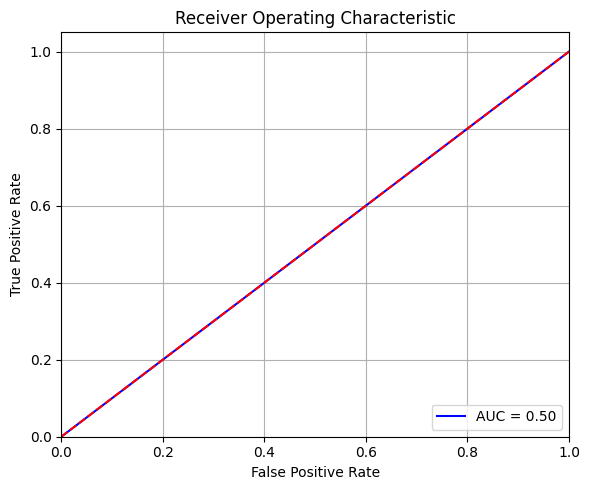

In [24]:
X_test_rbf = rbf_feature.transform(X_test)
y_pred = clf.predict(X_test_rbf)
model_performance('Kernel approximation with SGD', X_train_rbf, y_train, y_test, y_pred)


The Receiver Operating Characteristic (ROC) curve with an Area Under the Curve (AUC) of 0.50 indicates that the model's performance is equivalent to random guessing, as it aligns with the diagonal line, suggesting no discriminative ability between positive and negative classes.

**Random Forest Classifier**

Model name: Random Forest Classifier
Test accuracy (Accuracy Score): 0.8071
Test accuracy (ROC AUC Score): 0.5450
Area Under the Precision-Recall Curve: 0.4552


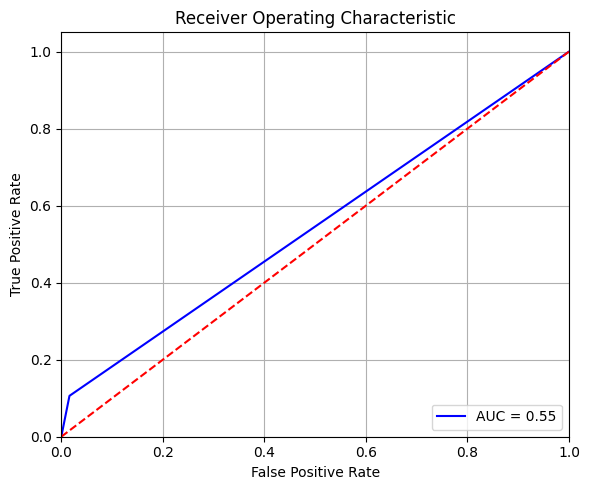

In [25]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_performance('Random Forest Classifier', X_train, y_train, y_test, y_pred)


The Receiver Operating Characteristic (ROC) curve with an Area Under the Curve (AUC) of 0.55 indicates slightly better than random guessing performance (AUC = 0.5), but the model still has limited ability to distinguish between positive and negative classes effectively.

**Gradient Boosting Classifier**

Model name: Gradient Boosting Classifier
Test accuracy (Accuracy Score): 0.8001
Test accuracy (ROC AUC Score): 0.5100
Area Under the Precision-Recall Curve: 0.4082


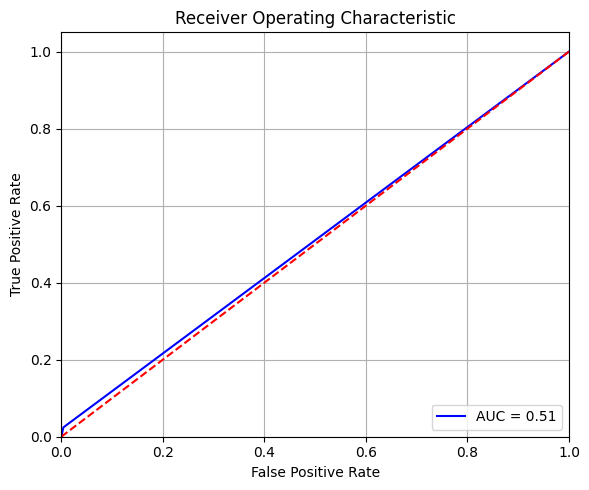

In [26]:

# Initialize and train the model
clf = GradientBoostingClassifier(
    random_state=10,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    max_features='sqrt'  # or a specific integer like 10
)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
model_performance('Gradient Boosting Classifier', X_train, y_train, y_test, y_pred)


The Receiver Operating Characteristic (ROC) curve with an Area Under the Curve (AUC) of 0.51 indicates that the model's performance is nearly equivalent to random guessing (AUC = 0.5), showing very limited ability to differentiate between positive and negative classes.
